In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from model import *
from utils import *
import pickle as pkl
import os
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set(style='whitegrid')
device = torch.device("cuda")

In [2]:
train_losses_mup = pkl.load(open("assets_singleindex/train_losses_mup.pkl", "rb"))
train_losses_ntk = pkl.load(open("assets_singleindex/train_losses_ntk.pkl", "rb"))

In [3]:
def sample_batch_singindex(B, d_in, device="cuda"):
    x = torch.randn(B, d_in, device=device) / math.sqrt(d_in)
    y = f_hermite(x @ teacher_weights).reshape(-1, 1)
    return x, y

def train_model(d_in, widths, B, T, lrs, sample_batch_fn, device="cuda", type="mup"):
    train_losses = {w: {lr:[] for lr in lrs} for w in widths}
    loss_fn = nn.MSELoss()
    for width in widths:
        for lr in lrs:
            has_nan = False
            model = MLP2Hidden(d_in, width, 1).to(device)
            if type == "mup":
                model.init_weights_mup()
                optimizer = model.init_optimizer_mup(lr, optimizer="Adam")
            elif type == "ntk":
                model.init_weights_ntk()
                optimizer = model.init_optimizer_ntk(lr)
            else:
                raise ValueError("Invalid type")
            model.train()
            for step in range(T):
                if has_nan:
                    train_losses[width][lr].append(np.nan)
                    continue
                x, y_true = sample_batch_fn(B, d_in, device=device)
                optimizer.zero_grad()
                y_pred = model(x)
                loss = loss_fn(y_pred, y_true)
                loss.backward()
                optimizer.step()
                train_losses[width][lr].append(loss.item())
                if torch.isnan(loss):
                    has_nan = True
                if step % 2000 == 0 and step > 100:
                    print(f"Step {step} for width {width}, lr {lr}, Loss: {np.mean(train_losses[width][lr][-1000:])}")
            if has_nan:
                print(f"Model {width} with lr {lr} has NaN loss")
    return train_losses

In [4]:
d_in = 16
def f_hermite(x): return (x**3 - 3*x)/math.sqrt(6)
torch.manual_seed(32)
teacher_weights = torch.randn(d_in, 1, device=device)
teacher_weights /= teacher_weights.norm()
teacher_weights *= math.sqrt(d_in)

Step 2000 for width 512, lr 0.001, Loss: 0.8188384290635585
Step 4000 for width 512, lr 0.001, Loss: 0.4104724417179823
Step 6000 for width 512, lr 0.001, Loss: 0.26368241626769306
Step 8000 for width 512, lr 0.001, Loss: 0.20459432815015316
Step 10000 for width 512, lr 0.001, Loss: 0.1654819437712431
Step 12000 for width 512, lr 0.001, Loss: 0.13945811308175327
Step 14000 for width 512, lr 0.001, Loss: 0.11619699186459184
Step 16000 for width 512, lr 0.001, Loss: 0.10565405508130789
Step 18000 for width 512, lr 0.001, Loss: 0.08676314835436642
Step 20000 for width 512, lr 0.001, Loss: 0.07455577109754086
Step 22000 for width 512, lr 0.001, Loss: 0.06502731357887387
Step 24000 for width 512, lr 0.001, Loss: 0.05482933765463531
Step 26000 for width 512, lr 0.001, Loss: 0.04447246737405658
Step 28000 for width 512, lr 0.001, Loss: 0.03805328517220914
Step 30000 for width 512, lr 0.001, Loss: 0.0351105756405741
Step 32000 for width 512, lr 0.001, Loss: 0.03142575375922024
Step 34000 for w

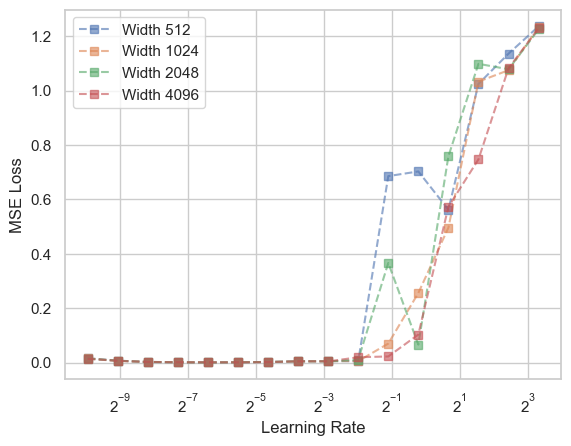

In [4]:
widths = [512, 1024, 2048, 4096]
lrs = np.logspace(-3.0, 1.0, 16)
B = 2048
T = 50001
type = "mup"
train_losses_mup = train_model(d_in, widths, B, T, lrs, sample_batch_singindex, device, type)
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses_mup[width][lr][-3000:]) for lr in lrs ]
        plt.plot(lrs , t_losses, marker='s', alpha=0.6, linestyle='--', label=f'Width {width}')
plt.xscale('log', base=2)
plt.xlabel("Learning Rate")
plt.ylabel("MSE Loss")
plt.legend()

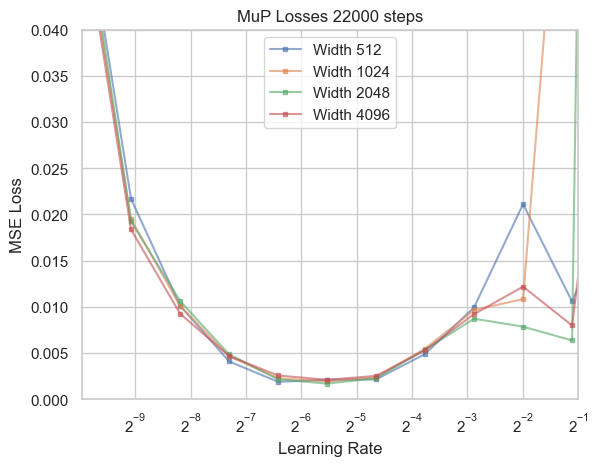

In [81]:
lrs = np.logspace(-3.0, 1.0, 16)
widths = [512, 1024, 2048, 4096]
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses_mup[width][lr][22000:24000]) for lr in lrs ]
        plt.plot(lrs , t_losses, marker='s', alpha=0.6, markersize=3, label=f'Width {width}')
plt.xscale('log', base=2)
plt.xlabel("Learning Rate")
plt.ylabel("MSE Loss")
plt.title("MuP Losses 22000 steps")
plt.ylim(0.0, 0.04)
plt.xlim(0.001, 0.5)
plt.legend()

Step 2000 for width 512, lr 0.0625, Loss: 0.990918117761612
Step 4000 for width 512, lr 0.0625, Loss: 0.9117527730464935
Step 6000 for width 512, lr 0.0625, Loss: 0.7673737936615944
Step 8000 for width 512, lr 0.0625, Loss: 0.6395373705327511
Step 10000 for width 512, lr 0.0625, Loss: 0.5256210875511169
Step 12000 for width 512, lr 0.0625, Loss: 0.44852672012150285
Step 14000 for width 512, lr 0.0625, Loss: 0.4049645349681377
Step 16000 for width 512, lr 0.0625, Loss: 0.3785185479819775
Step 18000 for width 512, lr 0.0625, Loss: 0.3558389022946358
Step 20000 for width 512, lr 0.0625, Loss: 0.3340722070634365
Step 22000 for width 512, lr 0.0625, Loss: 0.3226048717796802
Step 24000 for width 512, lr 0.0625, Loss: 0.3003259484618902
Step 26000 for width 512, lr 0.0625, Loss: 0.29404252964258193
Step 28000 for width 512, lr 0.0625, Loss: 0.2710312774926424
Step 30000 for width 512, lr 0.0625, Loss: 0.26632678720355035
Step 32000 for width 512, lr 0.0625, Loss: 0.24885899443924428
Step 3400

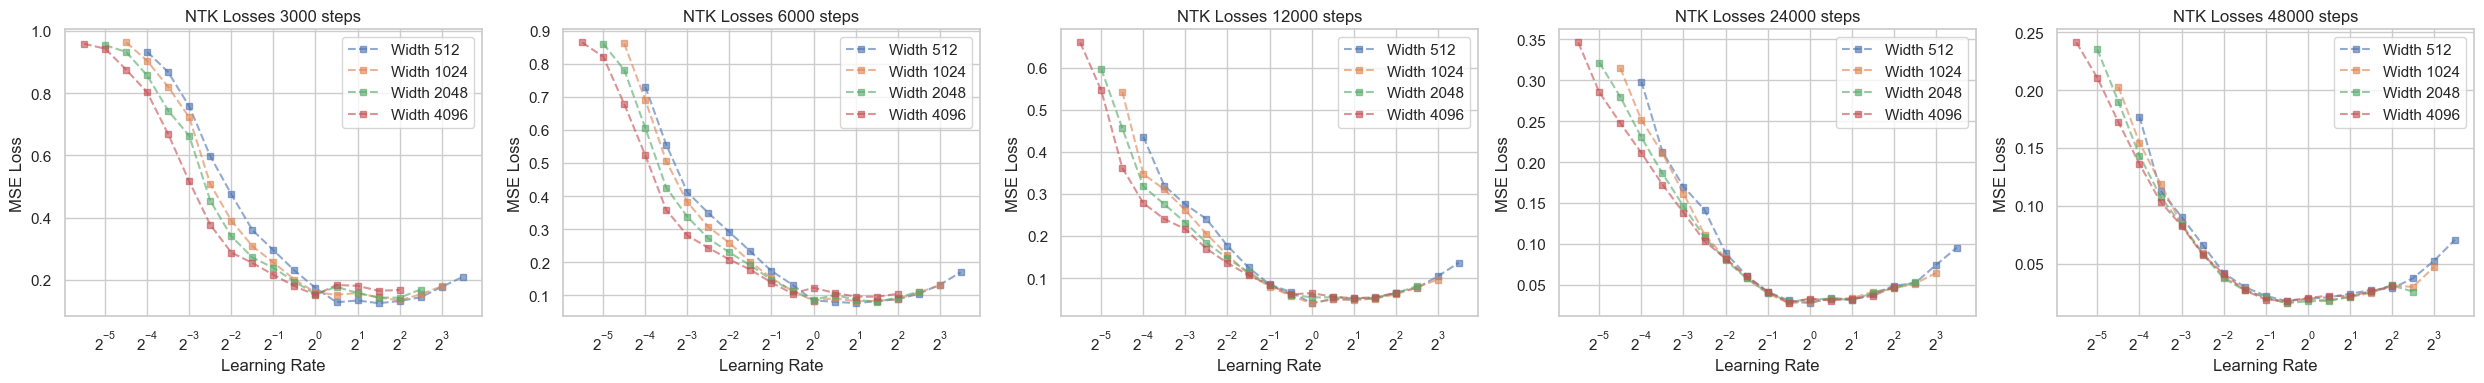

In [ ]:
widths = [512, 1024, 2048, 4096,]
lrs = np.logspace(-4.0, 6.0, 21, base=2)
B = 2048
T = 50001
type = "ntk"
train_losses_ntk = train_model(d_in, widths, B, T, lrs, sample_batch_singindex, device, type)

steps = [3000, 6000, 12000, 24000, 48000]
fig, axes = plt.subplots(1, len(steps), figsize=(5*len(steps), 4))
for i in range(len(steps)):
        S = steps[i]
        ax = axes[i]
        for idx, width in enumerate(widths):
                t_losses = [np.mean(train_losses_ntk[width][lr][S-1000:S+1000]) for lr in lrs ]
                ax.plot(lrs * np.sqrt(512) / np.sqrt(width), t_losses, marker='s', alpha=0.6, markersize=4.5, linestyle='--', label=f'Width {width}')
        ax.set_xscale('log', base=2)
        ax.set_xlabel("Learning Rate")
        ax.set_ylabel("MSE Loss")
        ax.set_title(f"NTK Losses {S} steps")
        ax.legend()
plt.tight_layout()
plt.show()

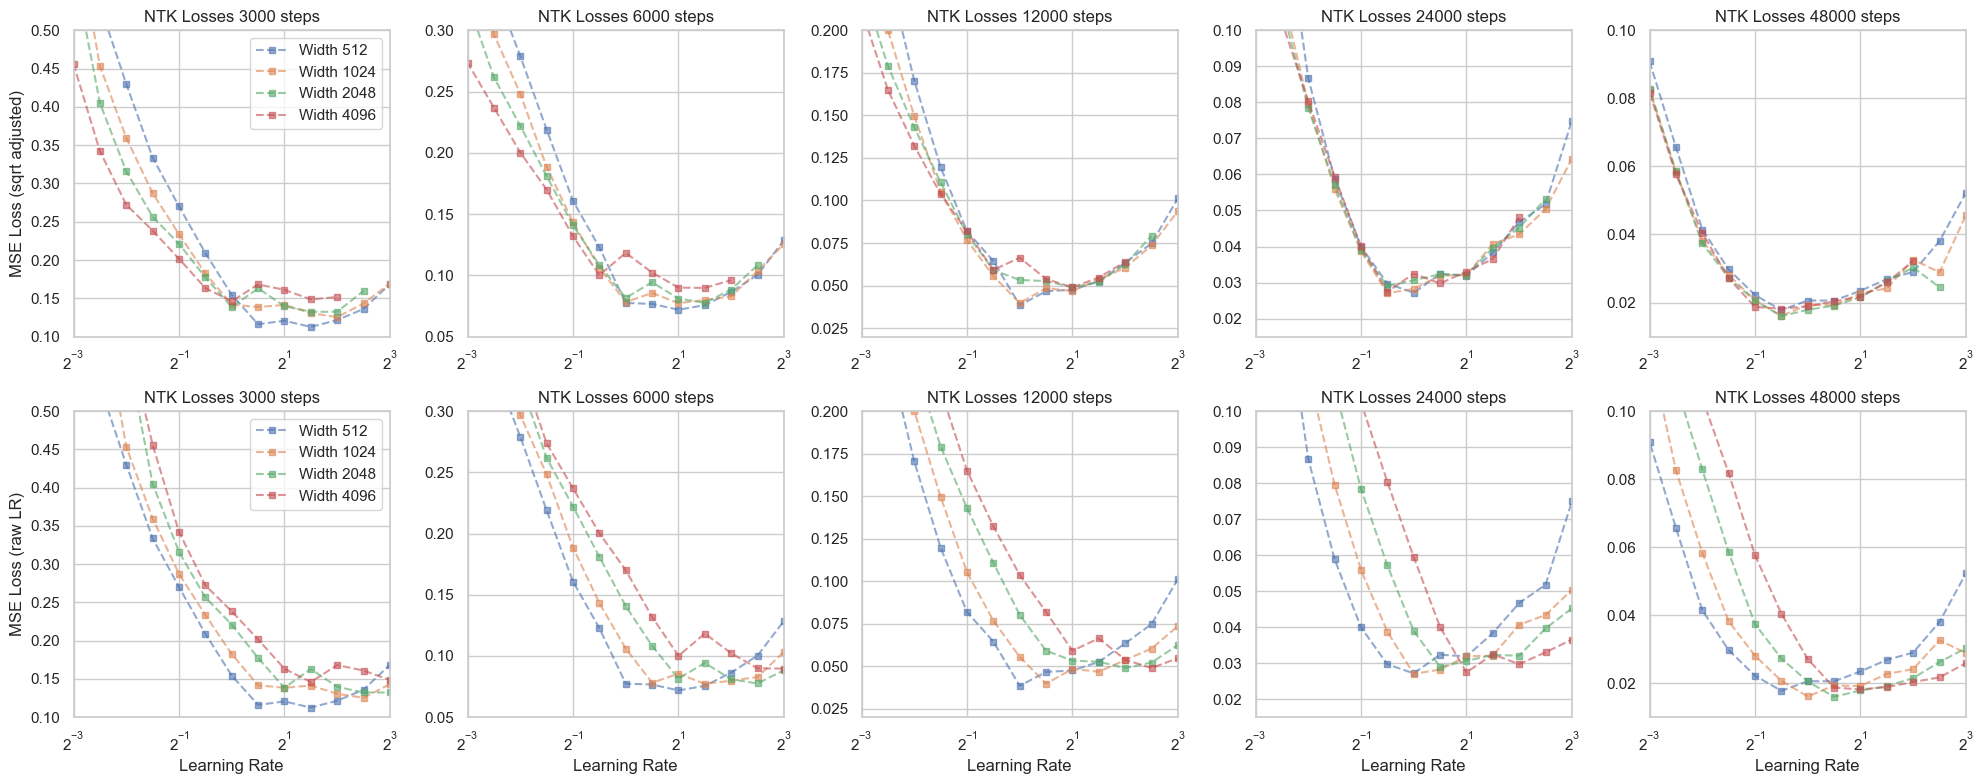

In [6]:
steps = [3000, 6000, 12000, 24000, 48000]
widths = [512, 1024, 2048, 4096,]
fig, axes = plt.subplots(2, len(steps), figsize=(4*len(steps), 8))
lrs = np.logspace(-4.0, 6.0, 21, base=2)
y_min = [0.1, 0.05, 0.02, 0.015, 0.01]
y_max = [0.5, 0.3, 0.2, 0.10, 0.10]
for i in range(len(steps)):
        S = steps[i]
        ax = axes[0, i]
        for idx, width in enumerate(widths):
                t_losses = [np.mean(train_losses_ntk[width][lr][S-1000:S+2000]) for lr in lrs ]
                ax.plot(lrs * np.sqrt(512) / np.sqrt(width), t_losses, marker='s', alpha=0.6, markersize=4.5, linestyle='--', label=f'Width {width}')
        ax.set_xscale('log', base=2)
        ax.set_xlim(2**-3, 2**3)
        if i == 0:
            ax.set_ylabel("MSE Loss (sqrt adjusted)")
            ax.legend()
        ax.set_ylim(y_min[i], y_max[i])
        ax.set_title(f"NTK Losses {S} steps")
        ax = axes[1, i]
        for idx, width in enumerate(widths):
                t_losses = [np.mean(train_losses_ntk[width][lr][S-1000:S+2000]) for lr in lrs ]
                ax.plot(lrs , t_losses, marker='s', alpha=0.6, markersize=4.5, linestyle='--', label=f'Width {width}')
        ax.set_xscale('log', base=2)
        ax.set_xlim(2**-3, 2**3)
        ax.set_xlabel("Learning Rate")
        if i == 0:
            ax.set_ylabel("MSE Loss (raw LR)")
            ax.legend()
        ax.set_ylim(y_min[i], y_max[i])
        ax.set_title(f"NTK Losses {S} steps")
plt.tight_layout()
plt.show()

In [ ]:
pkl.dump(train_losses_ntk, open("assets_singleindex/train_losses_ntk.pkl", "wb"))
pkl.dump(train_losses_mup, open("assets_singleindex/train_losses_mup.pkl", "wb"))